#  수어 번역기 파이프라인

* 데이터 출처 : https://www.kaggle.com/datasets/datamunge/sign-language-mnist?select=sign_mnist_train

## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import cv2
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

np.set_printoptions(linewidth=np.inf)

In [3]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

In [7]:
path = 'data/'
file = 'sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [8]:
data.shape

(8000, 785)

### (3) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [9]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

## 2 데이터 살펴보기

### (1) 데이터 한 건을 2차원으로 변환하고 그림 그리기

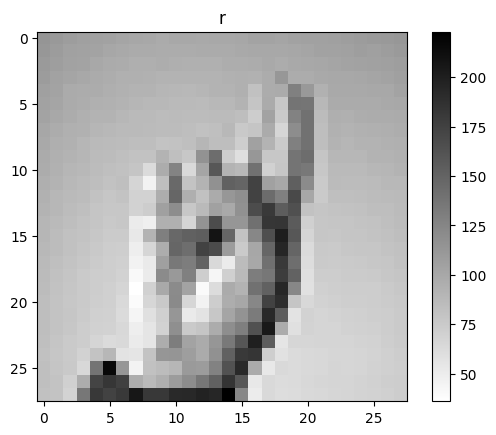

In [10]:
# 아래 숫자를 바꿔가며 화면에 그려 봅시다.
n = 100
sign_fig = data.iloc[n, 1:].values
sign_fig = sign_fig.reshape(28, 28)

sign = class_names[data.iloc[n,0]]

plt.title(sign)
plt.imshow(255-sign_fig, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

## 3.데이터 준비

* 주어진 데이터셋
    * 2차원 데이터셋, 1차원 데이터포인트(분석단위, 예측단위) 입니다. 
    * 흑백 이미지데이터
    * 이 데이터로부터 데이터 준비작업을 수행합니다.
        * 데이터 분할1 : x, y
        * 데이터 분할2 : train, validation
        * 만약 CNN으로 모델링을 한다면, shape를 맞춰야 합니다. (n, 28, 28, 1) 
        * scaling
* 그러나 운영에서 발생될 데이터는 이미지 한장 한장 입니다. 이미지 한장, 한장 들어온다면 어떻게 데이터가 처리되어야 할까요?(Data Pipeline 구성)

### (1) 데이터 분할1 : x, y 나누기

In [11]:
X = data.iloc[:, 1:].values  # 이미지 데이터
y = data.iloc[:, 0].values   # 클래스 레이블

### (2) 데이터 분할2 : train, validation

* train : val : test = 5000 : 2000 : 1000
* 여기서 test set은 파이프라인 점검을 위한 용도로 사용합니다.

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3333, random_state=42)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 5600 samples
Validation set: 1600 samples
Test set: 800 samples


In [14]:
# 모두 넘파이로 변환

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.int32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int32)

### (3) shape 맞추기 n, 28,28,1

* reshape
    * x_train.shape : (-1, 28, 28, 1)
    * x_val.shape : (-1, 28, 28, 1)

In [15]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)

In [16]:
print(f"x_train.shape: {X_train.shape}")
print(f"x_val.shape: {X_val.shape}")

x_train.shape: (5600, 28, 28, 1)
x_val.shape: (1600, 28, 28, 1)


### (4) Scaling : Min-Max

* 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
* x_train, x_test를 그냥 255로 나누면 됨

In [25]:
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

## 4.모델링

### (1) 모델 설계

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [21]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(26, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 576)              

### (2) 학습

In [22]:
history = model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_val_scaled, y_val))


Epoch 1/10
175/175 [==============================] - 3s 12ms/step - loss: 2.8175 - accuracy: 0.1561 - val_loss: 2.0407 - val_accuracy: 0.3738
Epoch 2/10
175/175 [==============================] - 2s 11ms/step - loss: 1.4773 - accuracy: 0.5425 - val_loss: 1.0247 - val_accuracy: 0.6819
Epoch 3/10
175/175 [==============================] - 2s 11ms/step - loss: 0.7298 - accuracy: 0.7680 - val_loss: 0.5857 - val_accuracy: 0.8012
Epoch 4/10
175/175 [==============================] - 2s 11ms/step - loss: 0.4074 - accuracy: 0.8693 - val_loss: 0.3758 - val_accuracy: 0.8869
Epoch 5/10
175/175 [==============================] - 2s 12ms/step - loss: 0.2645 - accuracy: 0.9204 - val_loss: 0.2303 - val_accuracy: 0.9294
Epoch 6/10
175/175 [==============================] - 2s 12ms/step - loss: 0.1589 - accuracy: 0.9532 - val_loss: 0.1525 - val_accuracy: 0.9569
Epoch 7/10
175/175 [==============================] - 2s 12ms/step - loss: 0.1046 - accuracy: 0.9725 - val_loss: 0.1260 - val_accuracy: 0.9631

### (3) 학습결과 그래프

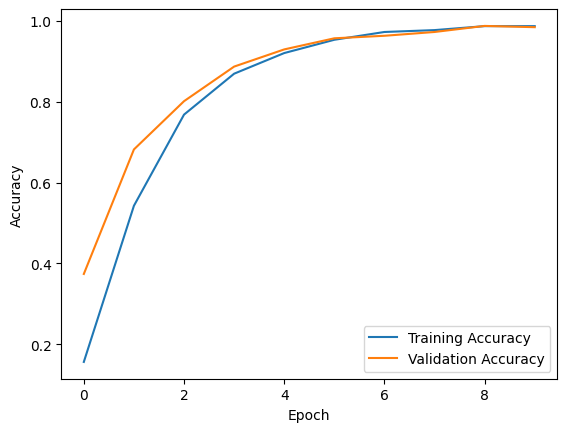

In [23]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### (4) 예측 및 검증

Model Input Shape: (None, 28, 28, 1)
X_test_scaled Shape: (800, 784)
Model Input Shape after Reshaping: (None, 28, 28, 1)
25/25 [==============================] - 0s 5ms/step - loss: 0.0762 - accuracy: 0.9762
Test Accuracy: 0.9762499928474426
25/25 [==============================] - 0s 4ms/step


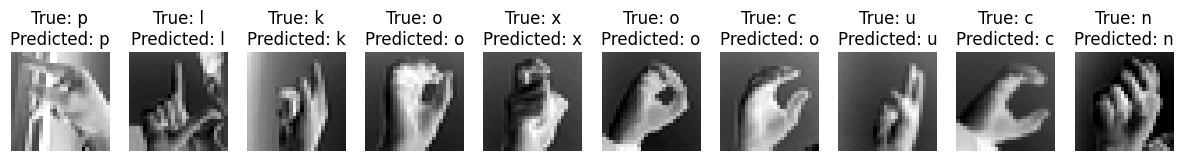

In [32]:
print(model.input_shape)
print("X_test_scaled Shape:", X_test_scaled.shape)

X_test_scaled_4D = X_test_scaled.reshape(-1, 28, 28, 1)

print("Model Input Shape after Reshaping:", model.input_shape)

test_loss, test_acc = model.evaluate(X_test_scaled_4D, y_test)
print(f"Test Accuracy: {test_acc}")

predictions = model.predict(X_test_scaled_4D)
predicted_labels = np.argmax(predictions, axis=1)

n = 10  
plt.figure(figsize=(15, 3))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.title(f"True: {class_names[y_test[i]]}\nPredicted: {class_names[predicted_labels[i]]}")
    plt.axis('off')
plt.show()


## 5.저장하기

* 여기서는 joblib을 이용하여 모델과 데이터셋을 저장하겠습니다.

### (1) 모델 저장하기

In [1]:
import joblib

joblib.dump(model, 'model.joblib')

NameError: name 'model' is not defined

### (2) 모델 로딩하기
* 로딩시 model2로 저장합니다.

In [34]:
model2 = joblib.load('model.joblib')

### (3) test 셋으로 예측하고 평가해보기

* test 셋에 필요한 전처리는 다음과 같습니다.
    * 넘파이 어레이로 변환
    * 4차원 데이터셋으로 변환
    * 스케일링

In [35]:
# 넘파이 어레이로 변환
X_test_for_prediction = X_test.astype(np.float32)

# 4차원 데이터셋
X_test_for_prediction = X_test_for_prediction.reshape(-1, 28, 28, 1) 

# 스케일링
X_test_for_prediction_scaled = X_test_for_prediction / 255.0 

In [36]:
# 예측하고 평가하기

predictions_test = model2.predict(X_test_for_prediction_scaled)
predicted_labels_test = np.argmax(predictions_test, axis=1)

25/25 [==============================] - 0s 4ms/step


In [37]:
test_loss_test, test_acc_test = model2.evaluate(X_test_for_prediction_scaled, y_test)
print(f"Test Accuracy of model2: {test_acc_test}")

25/25 [==============================] - 0s 4ms/step - loss: 0.0762 - accuracy: 0.9762
Test Accuracy of model2: 0.9762499928474426


## 6.Data Pipeline 구성

### (1) 라이브러리 로딩

In [38]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

### (2) 테스트 데이터 로딩
* 제공받은 이미지로 테스트 해보기
* 직접 찍은 사진으로 테스트 해보기

In [39]:
# 파일 열기
path = 'test image/'
file = 'v.png'
filename = path + file

img = cv2.imread(filename)
cv2.imshow('img', img)

cv2.waitKey(0) # 키보드 입력 대기
cv2.destroyAllWindows() # 키보드 입력이 있으면 이미지 창 닫기

### (3) Data Pipeline에 포함되어야 할 절차
* 이미지 크기 맞추기
* 흑백이미지
* 스케일링

#### 1)이미지 읽을 때 흑백으로 읽기

In [40]:
# 파일 열기
img = cv2.imread(filename , cv2.IMREAD_GRAYSCALE)

# 조회는 파이프라인 불필요
print(img.shape)
cv2.imshow('img', img)
cv2.waitKey(0) # 키보드 입력 대기
cv2.destroyAllWindows() # 키보드 입력이 있으면 이미지 창 닫기

(260, 228)


#### 2)이미지 크기를 28, 28, 1 로 맞추기
* 이미지 크기를 조절하는 방법은 크게 두가지 입니다.
    * numpy 
    * opencv의 resize 함수 이용

In [41]:
# 크기 조절하기
img = cv2.resize(img, (28, 28))

# 조회는 파이프라인 불필요
print(img.shape)
cv2.imshow('img', img)
cv2.waitKey(0) # 키보드 입력 대기
cv2.destroyAllWindows() # 키보드 입력이 있으면 이미지 창 닫기

(28, 28)


In [54]:

img_resized = img.astype(np.float32)  
img_resized = img_for_prediction.reshape(1, 28, 28, 1)

#### 3)스케일링

In [55]:
img_scaled = img_resized.astype(np.float32) / 255.0

#### 4)모델 로딩하기

In [59]:
model2 = joblib.load('model.joblib')

#### 5)예측하기

In [61]:
prediction = model2.predict(img_scaled) 
predicted_label = np.argmax(prediction, axis=1)

print(f"Predicted Label for {filename}: {class_names[predicted_label[0]]}")


1/1 [==============================] - 0s 15ms/step
Predicted Label for test image/v.png: i


### (4) 하나의 셀로 합치기

* 코드를 하나로 모으기

In [63]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

# class names 준비
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

# 파일 로딩
path = 'test image/'
file = 'v.png'
filename = path + file

# 흑백으로 읽기
# 파일 열기
img = cv2.imread(filename , cv2.IMREAD_GRAYSCALE)

# 조회는 파이프라인 불필요
print(img.shape)
cv2.imshow('img', img)
cv2.waitKey(0) # 키보드 입력 대기
cv2.destroyAllWindows() # 키보드 입력이 있으면 이미지 창 닫기

# 크기 조정
img = cv2.resize(img, (28, 28))

# input shape 맞추기
img_resized = img.astype(np.float32)  
img_resized = img_for_prediction.reshape(1, 28, 28, 1)

# 스케일링
img_scaled = img_resized.astype(np.float32) / 255.0

# 모델 로딩
model2 = joblib.load('model.joblib')

# 예측
prediction = model2.predict(img_scaled) 
predicted_label = np.argmax(prediction, axis=1)

print(f"Predicted Label for {filename}: {class_names[predicted_label[0]]}")


(260, 228)
1/1 [==============================] - 0s 63ms/step
Predicted Label for test image/v.png: p
